In [ ]:
!pip install numpy==1.26.4 --quiet

In [ ]:
!pip install -q transformers datasets evaluate

In [ ]:
!pip install -q -U transformers

In [ ]:
!pip install -q emoji

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
from datasets import Dataset, DatasetDict
import evaluate
import re
import emoji

In [6]:
# Load dataset
df = pd.read_csv("/content/Mental-Health-Twitter.csv")
df.head()

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [7]:
# Only take necessary columns
df = df[['post_text','label']].copy()

In [8]:
# Function for cleaning the text
def clean_text(text):
    if pd.isna(text):
        return ""

    text = str(text)
    text = re.sub(r"http\S+", "", text)             # Remove URLs
    text = re.sub(r"@\w+", "", text)                # Remove mentions
    text = re.sub(r"#\w+", "", text)                # Remove hashtags
    text = emoji.replace_emoji(text, replace="")    # Remove emojis
    text = re.sub(r"\s+", " ", text).strip()        # Remove extra whitespace
    text = text.lower()                             # Lowercase
    return text

In [9]:
# Clean text in dataframe
df['post_text'] = df['post_text'].apply(clean_text)

In [10]:
# Show the label distribution
df['label'].value_counts()

,count
label,
1,10000
0,10000


In [11]:
# Split dataset into train(60%), val(20%) and test(20%)

X_train, X_temp, y_train,y_temp = train_test_split(df['post_text'], df['label'], test_size=0.4, stratify=df['label'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print size of train, val and test datasets
print(f"Train: {len(X_train)}\nValidation: {len(X_val)}\nTest: {len(X_test)}")

Train: 12000
Validation: 4000
Test: 4000


In [12]:
# Convert labels to NumPy arrays
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
y_test_np = np.array(y_test)

In [13]:
# Build Hugging Face Dataset objects
train_ds = Dataset.from_dict({"text": X_train.tolist(), "label": y_train_np.tolist()})
val_ds = Dataset.from_dict({"text": X_val.tolist(), "label": y_val_np.tolist()})
test_ds = Dataset.from_dict({"text": X_test.tolist(), "label": y_test_np.tolist()})

# Combine Datasets into a Dataset Dict
dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

In [ ]:
# Load pre-trained tokenizer for Distil BERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
# Function to tokenize an example
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Apply tokenizer to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [16]:
# Prepare dataset for training
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")  # Needed for PyTorch models

In [ ]:
# Load pre-trained Distil BERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2  # Binary classification: 0 (non-depressed), 1 (depressed)
)

In [18]:
# Load the evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

# Function to compute metrics after each evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # label with highest score
    return {
        "accuracy": (accuracy.compute(predictions=predictions, references=labels))["accuracy"],
        "f1": (f1.compute(predictions=predictions, references=labels, average='weighted'))["f1"],
        "precision": (precision.compute(predictions=predictions, references=labels, average='weighted'))["precision"],
        "recall": (recall.compute(predictions=predictions, references=labels, average='weighted'))["recall"],
    }

In [19]:
# Set up the training arguments
training_args = TrainingArguments(
    output_dir="./bert-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)

In [ ]:
# Create trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

In [21]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.523900,0.458565,0.766000,0.762639,0.781972,0.766000
2,0.408900,0.438634,0.780000,0.779449,0.782828,0.780000


TrainOutput(global_step=1500, training_loss=0.4663616536458333, metrics={'train_runtime': 329.4461, 'train_samples_per_second': 72.85, 'train_steps_per_second': 4.553, 'total_flos': 794804391936000.0, 'train_loss': 0.4663616536458333, 'epoch': 2.0})

In [22]:
# Evaluate model on test set
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

{'eval_loss': 0.4422507584095001,
 'eval_accuracy': 0.77975,
 'eval_f1': 0.7791470576641141,
 'eval_precision': 0.7828386689748729,
 'eval_recall': 0.77975,
 'eval_runtime': 14.8507,
 'eval_samples_per_second': 269.347,
 'eval_steps_per_second': 16.834,
 'epoch': 2.0}

In [ ]:
# Tokenize test set
tokenized_test = dataset["test"].map(tokenize_function, batched=True)

tokenized_test = tokenized_test.remove_columns(["text"])

# Set the format to PyTorch tensors
tokenized_test.set_format("torch")

In [24]:
# Model prediction on test set
preds_output = trainer.predict(tokenized_test)

# True labels
y_true = preds_output.label_ids

# Take the index 0 or 1 with highest probability
y_pred = preds_output.predictions.argmax(axis=-1)

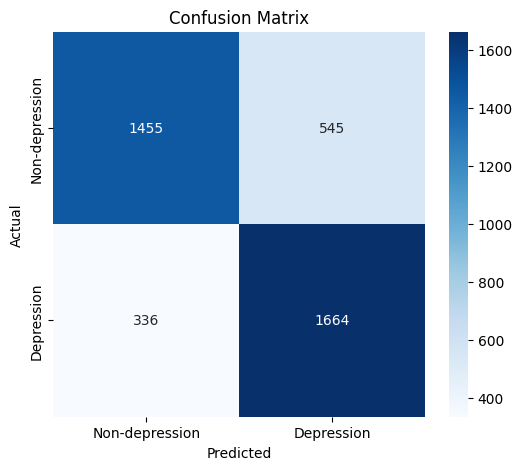

In [25]:
# Create the confusion matrix using actual and predicted labels
cm = confusion_matrix(y_true, y_pred)

# Set plot figure size
plt.figure(figsize=(6, 5))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-depression", "Depression"], yticklabels=["Non-depression", "Depression"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
# Get all the logs from training from each epoch
logs = trainer.state.log_history
df = pd.DataFrame(logs)

# Filter out non-null losses
train_loss = df[df["loss"].notnull()]
eval_loss = df[df["eval_loss"].notnull()]

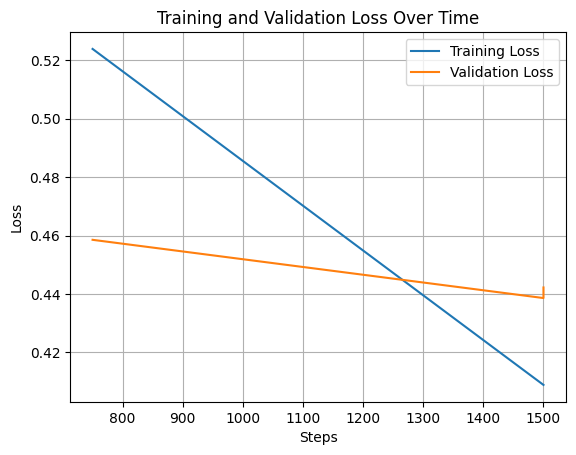

In [27]:
# Plot train and val losses
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Over Time")
plt.grid(True)
plt.show()

In [28]:
# Create dataframe for test metrics
results_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1", "Precision", "Recall"],
    "Score": [
        accuracy.compute(predictions=y_pred, references=y_true)["accuracy"],
        f1.compute(predictions=y_pred, references=y_true, average="weighted")["f1"],
        precision.compute(predictions=y_pred, references=y_true, average="weighted")["precision"],
        recall.compute(predictions=y_pred, references=y_true, average="weighted")["recall"],
    ]
})

In [29]:
# Test metrics
results_df

,Metric,Score
0,Accuracy,0.779750
1,F1,0.779147
2,Precision,0.782839
3,Recall,0.779750
